# Práctica 8: Análisis de varianza y de componentes principales

El análisis de varianza (**ANOVA**) es una herramienta estadística que nos permite determinar si una variable independiente tiene efecto significativo sobre una variable de interés. Antes de poder realizar el **ANOVA** es necesario poner de forma explicita como es el modelo que representa el problema. Al igual que en practicas pasadas se hace uso de la librería [**StatsModels**](https://www.statsmodels.org/stable/index.html) para realizar el **ANOVA** y el análisis se hace para los datos de cada uno de los niveles del factor función de activación.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

d = pd.read_csv("../lbfgs_crudo.csv", index_col=0)
d_tanh=d.loc[d.activation=='tanh']
d_tanh = pd.DataFrame(d_tanh, columns = ['test_accuracy','partition','layer_num','neurona_num','alpha'])
d_log=d.loc[d.activation=='logistic']
d_log = pd.DataFrame(d_log, columns = ['test_accuracy','partition','layer_num','neurona_num','alpha'])

Los primeros datos que se analizan son aquellos en los que se usan una **función de activación logística**. Como primer paso se hace aplica el ANOVA para identificar los factores que tienen efecto sobre la precisión en el conjunto de prueba.

In [21]:
m_log = ols('test_accuracy ~ partition + layer_num + neurona_num + alpha', data = d_log).fit() 
a_log = sm.stats.anova_lm(m_log, typ = 2)
print(a_log)
n = len(a_log)
alfa = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a_log.index[i], "" if a_log['PR(>F)'][i] < alfa else "no "))

                 sum_sq      df            F    PR(>F)
partition      0.040586     1.0     0.793076  0.373221
layer_num    332.568407     1.0  6498.671902  0.000000
neurona_num    0.058425     1.0     1.141680  0.285357
alpha          0.083927     1.0     1.640003  0.200394
Residual     220.614677  4311.0          NaN       NaN
partition no es significativo
layer_num es significativo
neurona_num no es significativo
alpha no es significativo
Residual no es significativo


En este caso se tiene que solo el factor de numero de capas tiene un efecto significativo, lo cual ya ha aparecido en las practicas anteriores, sin embargo, se maneja con cuidado esta conclusión, aunque pudiera ser un caso especial. Es claro que la los residuales provienen de los errores del número de capas.El siguiente paso es identificar si existen interacciones entre los factores.

In [22]:
m = ols('test_accuracy ~ partition*layer_num + partition*neurona_num + partition*alpha + layer_num*neurona_num + \
        layer_num*alpha + neurona_num*alpha', data = d_log).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alfa = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alfa else "NO "))

                             sum_sq      df            F    PR(>F)
partition              4.079240e-02     1.0     0.797182  0.371987
layer_num              3.325666e+02     1.0  6499.156672  0.000000
partition:layer_num    6.725893e-02     1.0     1.314402  0.251663
neurona_num            5.864394e-02     1.0     1.146044  0.284439
partition:neurona_num  5.131034e-04     1.0     0.010027  0.920241
...                             ...     ...          ...       ...
partition:alpha        5.980128e-03     1.0     0.116866  0.732475
layer_num:neurona_num  1.247636e-01     1.0     2.438183  0.118487
layer_num:alpha        1.256727e-01     1.0     2.455948  0.117154
neurona_num:alpha      5.399260e-07     1.0     0.000011  0.997408
Residual               2.202900e+02  4305.0          NaN       NaN

[11 rows x 4 columns]
partition NO es significativo
layer_num es significativo
partition:layer_num NO es significativo
neurona_num NO es significativo
partition:neurona_num NO es significativo
al

Para este conjunto de datos no existe interacción entre los factores, por lo que parece ser un comportamiento simple uno a uno. Para terminar con estos datos se aplica un **análisis de componente principal**, el cual es una herramienta que permite describir el conjunto de datos en términos de nuevas variables las cuales son menos que el número de variables original (reducción de variables). Esto con la finalidad de obtener nuevas variables que en el plano permitan separar clases.

,comp_0,comp_1,test_accuracy
0,1.223171,-2.061458,0.8789
1,1.223188,-2.061427,0.8949
2,1.401699,-1.754129,0.8065
3,1.556816,-1.427152,0.1002
4,1.556834,-1.427121,0.0798


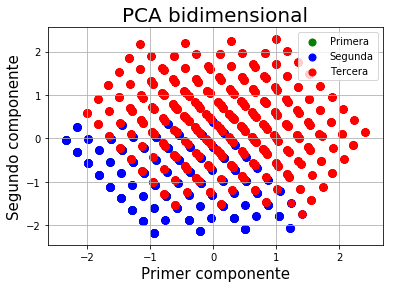

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['partition','layer_num','neurona_num','alpha']
x = d_log.loc[:, features].values
y = d_log.loc[:,['test_accuracy']].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components = 2)
cd = pd.DataFrame(data = pca.fit_transform(x), columns = ['comp_{:d}'.format(i) for i in range(k)])
cd['test_accuracy'] = y
display(cd.head(5))

n = len(cd)
pri = cd.test_accuracy >= 0.9
seg = cd.test_accuracy >= 0.8
ter = ~ (pri | seg)

plt.title('PCA bidimensional', fontsize = 20)
plt.xlabel('Primer componente', fontsize = 15)
plt.ylabel('Segundo componente', fontsize = 15)
plt.scatter(cd.loc[pri].comp_0, cd.loc[pri].comp_1, c = 'g', s = 50)
plt.scatter(cd.loc[seg].comp_0, cd.loc[seg].comp_1, c = 'b', s = 50)
plt.scatter(cd.loc[ter].comp_0, cd.loc[ter].comp_1, c = 'r', s = 50)
plt.legend(['Primera', 'Segunda', 'Tercera'])
plt.grid()

Ahora se pasa a analizar los datos en cuyo entrenamiento se uso la **función de activación tangente hiperbólica**.

In [23]:
m_tanh = ols('test_accuracy ~ partition + layer_num + neurona_num + alpha', data = d_tanh).fit() 
a_tanh = sm.stats.anova_lm(m_tanh, typ = 2)
print(a_tanh)
n = len(a_tanh)
alfa = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a_tanh.index[i], "" if a_tanh['PR(>F)'][i] < alfa else "no "))

                 sum_sq      df             F         PR(>F)
partition      0.397475     1.0     11.702320   6.300250e-04
layer_num     38.772659     1.0   1141.531415  3.392213e-222
neurona_num    0.592581     1.0     17.446572   3.013435e-05
alpha        374.883578     1.0  11037.194658   0.000000e+00
Residual     146.357239  4309.0           NaN            NaN
partition es significativo
layer_num es significativo
neurona_num es significativo
alpha es significativo
Residual no es significativo


En este caso se observa que todos los factores influyen sobre la variable de interés, también se observa que la variable que presenta mayor error cuadrado es la de *alpha*, debido a que en prácticas pasadas se comprobó que es necesario realizar una transformación para una regresión lineal. Lo siguiente es analizar las interacciones.

In [24]:
m = ols('test_accuracy ~ partition*layer_num + partition*neurona_num + partition*alpha + layer_num*neurona_num + \
        layer_num*alpha + neurona_num*alpha', data = d_tanh).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alfa = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alfa else "NO "))

                          sum_sq      df            F        PR(>F)
partition               0.397782     1.0    23.202134  1.508505e-06
layer_num              38.772984     1.0  2261.577546  0.000000e+00
partition:layer_num     0.002220     1.0     0.129464  7.190056e-01
neurona_num             0.592721     1.0    34.572658  4.417437e-09
partition:neurona_num   0.000387     1.0     0.022584  8.805518e-01
...                          ...     ...          ...           ...
partition:alpha         0.031002     1.0     1.808323  1.787804e-01
layer_num:neurona_num   0.015769     1.0     0.919798  3.375819e-01
layer_num:alpha        72.452081     1.0  4226.035357  0.000000e+00
neurona_num:alpha       0.087689     1.0     5.114811  2.377216e-02
Residual               73.771580  4303.0          NaN           NaN

[11 rows x 4 columns]
partition es significativo
layer_num es significativo
partition:layer_num NO es significativo
neurona_num es significativo
partition:neurona_num NO es significat

En este caso se tiene que las interacciones entre numero de capas-alpha y numero de neuronas-alpha son significativas sobre el rendimiento, esta conclusión ya se había mencionado en una practica anterior donde se mencionaba que era necesario un estudio de mayor detalle para la combinación de los niveles de algunos factores. Para finalizar se aplica el análisis de componente principal a este conjunto de datos.

,comp_0,comp_1,test_accuracy
0,-1.812765,1.529408,0.8854
1,-1.812765,1.529408,0.8725
2,-1.812765,1.529408,0.8672
3,-1.942239,0.781270,0.8762
4,-1.942239,0.781270,0.8783


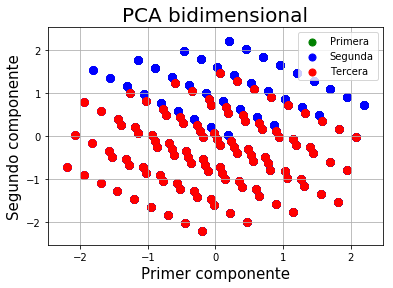

In [34]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

features = ['partition','layer_num','neurona_num','alpha']
x = d_tanh.loc[:, features].values
y = d_tanh.loc[:,['test_accuracy']].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components = 2)
cd = pd.DataFrame(data = pca.fit_transform(x), columns = ['comp_{:d}'.format(i) for i in range(k)])
cd['test_accuracy'] = y
display(cd.head(5))

n = len(cd)
pri = cd.test_accuracy >= 0.9
seg = cd.test_accuracy >= 0.8
ter = ~ (pri | seg)

plt.title('PCA bidimensional', fontsize = 20)
plt.xlabel('Primer componente', fontsize = 15)
plt.ylabel('Segundo componente', fontsize = 15)
plt.scatter(cd.loc[pri].comp_0, cd.loc[pri].comp_1, c = 'g', s = 50)
plt.scatter(cd.loc[seg].comp_0, cd.loc[seg].comp_1, c = 'b', s = 50)
plt.scatter(cd.loc[ter].comp_0, cd.loc[ter].comp_1, c = 'r', s = 50)
plt.legend(['Primera', 'Segunda', 'Tercera'])
plt.grid()